## 1. Loading the datasets
Dataset 1 --> Code Red  + Slammer

Ratio features: YES

Training: Code Red 559 1 Min + Slammer 559 1 Min

Test: Nimda 559 1 Min

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_recall_fscore_support, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings

# Import explainability libraries if installed
try:
    import shap
    EXPLAINABILITY_AVAILABLE = True
except ImportError:
    EXPLAINABILITY_AVAILABLE = False
    print("Warning: SHAP libraries not installed. Explainability sections will be skipped.")
    print("Run 'pip install shap' to install them.")

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

### 1.1 Loading the training dataset

In [2]:
# Load the first training dataset - update the path to the dataset file you want to use
dataset_path = "../../datasets/ratios/dataset_nimda_559_1_rrc04.csv"
df = pd.read_csv(dataset_path)

# Check the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (10336, 31)


,Unnamed: 0,announcements,as_path_max,class,nlri_ann,number_rare_ases,origin_changes,rare_ases_avg,rare_ases_max,ratio_ann,...,ratio_origin0,ratio_origin1,ratio_origin2,ratio_shorter,ratio_shorter2,ratio_wd,timestamp,timestamp2,unique_as_path_avg,withdrawals
0,0,38,15,0,21,0,0,0.0,0,0.926829,...,1.000000,0.0,0.000000,0.026316,0.050000,0.073171,2001-09-15 20:13:25,1000584805,6,3
1,1,43,14,0,26,0,1,0.0,0,0.716667,...,0.888889,0.0,0.111111,0.023256,0.052632,0.283333,2001-09-15 20:14:25,1000584865,5,17
2,2,9,10,0,8,0,2,0.0,0,0.333333,...,0.666667,0.0,0.333333,0.111111,1.000000,0.666667,2001-09-15 20:15:25,1000584925,5,18
3,3,39,10,0,32,0,0,0.0,0,0.975000,...,0.692308,0.0,0.307692,0.000000,0.000000,0.025000,2001-09-15 20:16:25,1000584985,9,1
4,4,73,10,0,37,0,0,0.0,0,1.000000,...,0.678571,0.0,0.321429,0.479452,0.875000,0.000000,2001-09-15 20:17:25,1000585045,5,0


In [3]:
# Load the second training dataset - update the path to the dataset file you want to use
dataset_path = "../../datasets/ratios/dataset_code-red_559_1_rrc04.csv"
df_2 = pd.read_csv(dataset_path)

# Check the first few rows
print(f"Dataset shape: {df_2.shape}")
df_2.head()

Dataset shape: (7136, 31)


,Unnamed: 0,announcements,as_path_max,class,nlri_ann,number_rare_ases,origin_changes,rare_ases_avg,rare_ases_max,ratio_ann,...,ratio_origin0,ratio_origin1,ratio_origin2,ratio_shorter,ratio_shorter2,ratio_wd,timestamp,timestamp2,unique_as_path_avg,withdrawals
0,0,115,11,0,112,0,0,0.0,0,0.982906,...,0.736842,0.0,0.263158,0.930435,0.955357,0.017094,2001-07-17 00:50:50,995331050,4,2
1,1,8,12,0,8,0,0,0.0,0,0.533333,...,0.833333,0.0,0.166667,0.125000,0.333333,0.466667,2001-07-17 00:51:50,995331110,8,7
2,2,20,13,0,18,0,0,0.0,0,0.588235,...,0.545455,0.0,0.454545,0.050000,0.250000,0.411765,2001-07-17 00:52:50,995331170,5,14
3,3,27,17,0,23,0,0,0.0,0,0.794118,...,0.529412,0.0,0.470588,0.037037,0.125000,0.205882,2001-07-17 00:53:50,995331230,4,7
4,4,21,7,0,20,0,0,0.0,0,1.000000,...,0.545455,0.0,0.454545,0.047619,0.200000,0.000000,2001-07-17 00:54:50,995331290,6,0


In [4]:
# Combine the training data
df = pd.concat([df, df_2])
print(f"Dataset shape: {df.shape}")

Dataset shape: (17472, 31)


### 1.2 Loading the testing dataset

In [5]:
# Load the test dataset
dataset_path = "../../datasets/ratios/dataset_slammer_559_1_rrc04.csv"   # CHANGE THIS
df_test = pd.read_csv(dataset_path)
df_test.head()

,Unnamed: 0,announcements,as_path_max,class,nlri_ann,number_rare_ases,origin_changes,rare_ases_avg,rare_ases_max,ratio_ann,...,ratio_origin0,ratio_origin1,ratio_origin2,ratio_shorter,ratio_shorter2,ratio_wd,timestamp,timestamp2,unique_as_path_avg,withdrawals
0,0,3,6,0,3,0,0,0.0,0,1.000000,...,1.0,0.0,0.0,0.000000,0.0,0.000000,2003-01-23 00:00:08,1043280008,7,0
1,1,3,6,0,3,0,0,0.0,0,0.103448,...,1.0,0.0,0.0,0.000000,0.0,0.896552,2003-01-23 00:01:08,1043280068,5,26
2,2,7,4,0,7,0,0,0.0,0,0.583333,...,1.0,0.0,0.0,0.000000,0.0,0.416667,2003-01-23 00:02:08,1043280128,4,5
3,3,21,6,0,21,0,0,0.0,0,0.840000,...,1.0,0.0,0.0,0.000000,0.0,0.160000,2003-01-23 00:03:08,1043280188,4,4
4,4,12,9,0,8,0,0,0.0,0,0.324324,...,1.0,0.0,0.0,0.333333,1.0,0.675676,2003-01-23 00:04:08,1043280248,7,25


## 2. Data Exploration and Preprocessing

### 2.1 Training Dataset

In [6]:
# Check basic statistics
df.describe()

,Unnamed: 0,announcements,as_path_max,class,nlri_ann,number_rare_ases,origin_changes,rare_ases_avg,rare_ases_max,ratio_ann,...,ratio_news,ratio_origin0,ratio_origin1,ratio_origin2,ratio_shorter,ratio_shorter2,ratio_wd,timestamp2,unique_as_path_avg,withdrawals
count,17472.00000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,...,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,17472.000000,1.747200e+04,17472.000000,17472.000000
mean,4514.01013,40.616071,9.774153,0.229338,34.475790,0.843120,0.187214,0.018729,0.268201,0.810190,...,0.018768,0.811175,0.001047,0.185087,0.243333,0.472792,0.189066,9.987099e+08,5.740957,11.179373
std,2760.19556,273.134521,3.059283,0.420419,269.139357,15.410278,1.204389,0.063472,0.556118,0.184576,...,0.075520,0.177819,0.011155,0.172919,0.207938,0.313282,0.183319,2.634494e+06,1.655485,254.435385
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.953310e+08,0.000000,0.000000
25%,2183.75000,10.000000,8.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.722222,...,0.000000,0.727273,0.000000,0.053933,0.078947,0.217391,0.050000,9.955931e+08,5.000000,1.000000
50%,4367.50000,20.000000,9.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.857143,...,0.000000,0.842105,0.000000,0.153846,0.200000,0.500000,0.142857,1.000681e+09,6.000000,3.000000
75%,6551.25000,38.000000,11.000000,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.950000,...,0.000000,0.943073,0.000000,0.272727,0.363636,0.714286,0.275862,1.000943e+09,7.000000,8.000000
max,10320.00000,26721.000000,31.000000,1.000000,26651.000000,1431.000000,54.000000,3.000000,7.000000,1.000000,...,1.000000,1.000000,0.285714,1.000000,1.000000,1.000000,1.000000,1.001204e+09,20.000000,29376.000000


In [7]:
# Check for missing values
print("Missing values in each column:")
df.isnull().sum()

Missing values in each column:


Unnamed: 0            0
announcements         0
as_path_max           0
class                 0
nlri_ann              0
number_rare_ases      0
origin_changes        0
rare_ases_avg         0
rare_ases_max         0
ratio_ann             0
ratio_dups            0
ratio_exp_wd          0
ratio_flaps           0
ratio_imp_wd          0
ratio_imp_wd2         0
ratio_imp_wd_dpath    0
ratio_imp_wd_spath    0
ratio_longer          0
ratio_longer2         0
ratio_nadas           0
ratio_news            0
ratio_origin0         0
ratio_origin1         0
ratio_origin2         0
ratio_shorter         0
ratio_shorter2        0
ratio_wd              0
timestamp             0
timestamp2            0
unique_as_path_avg    0
withdrawals           0
dtype: int64

In [8]:
# Fill missing values with 0 (if any)
df = df.fillna(0)

Class distribution:
class
0    13465
1     4007
Name: count, dtype: int64


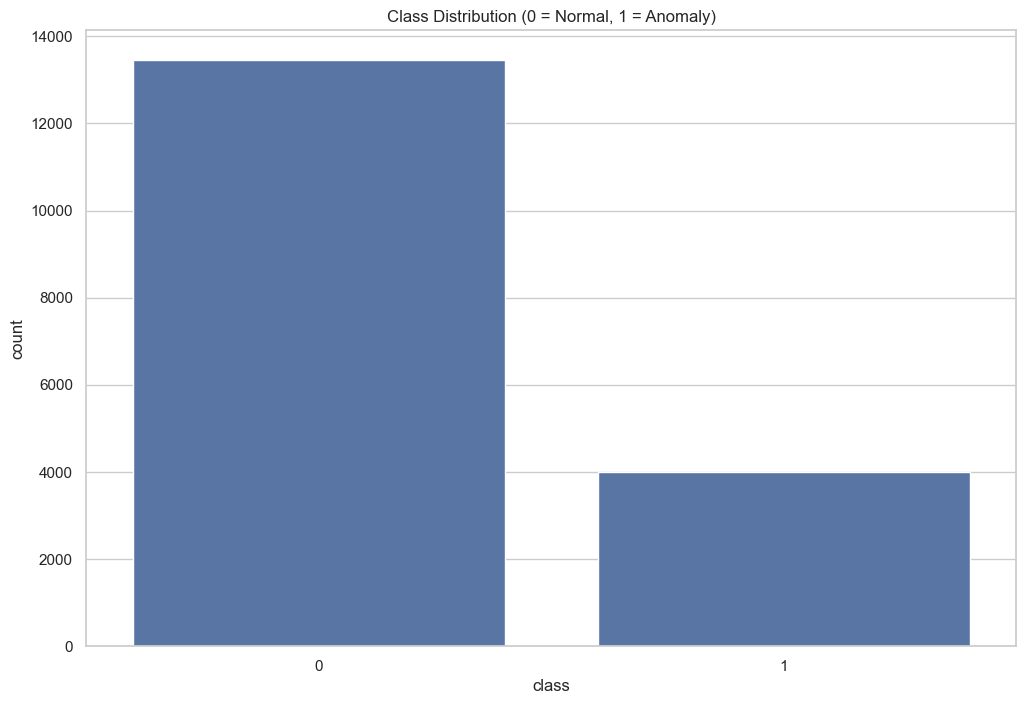

In [9]:
# Check class distribution
print("Class distribution:")
print(df['class'].value_counts())

# Plot class distribution
plt.figure(figsize=(12, 8))
sns.countplot(x='class', data=df)
plt.title('Class Distribution (0 = Normal, 1 = Anomaly)')
plt.show()

In [10]:
# Drop non-feature columns
columns_to_drop = ['timestamp', 'timestamp2', 'Unnamed: 0']
for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(col, axis=1)

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Display feature names
print(f"Number of features: {X.shape[1]}")
print("Feature names:")
X.columns.tolist()

Number of features: 27
Feature names:


['announcements',
 'as_path_max',
 'nlri_ann',
 'number_rare_ases',
 'origin_changes',
 'rare_ases_avg',
 'rare_ases_max',
 'ratio_ann',
 'ratio_dups',
 'ratio_exp_wd',
 'ratio_flaps',
 'ratio_imp_wd',
 'ratio_imp_wd2',
 'ratio_imp_wd_dpath',
 'ratio_imp_wd_spath',
 'ratio_longer',
 'ratio_longer2',
 'ratio_nadas',
 'ratio_news',
 'ratio_origin0',
 'ratio_origin1',
 'ratio_origin2',
 'ratio_shorter',
 'ratio_shorter2',
 'ratio_wd',
 'unique_as_path_avg',
 'withdrawals']

### 2.2 Test Dataset

In [11]:
# Drop non-feature columns
columns_to_drop = ['timestamp', 'timestamp2', 'Unnamed: 0']
for col in columns_to_drop:
    if col in df_test.columns:
        df_test = df_test.drop(col, axis=1)
y_test = df_test["class"]
X_test = df_test.drop(["class"], axis=1)

## 3. Feature Analysis and Selection

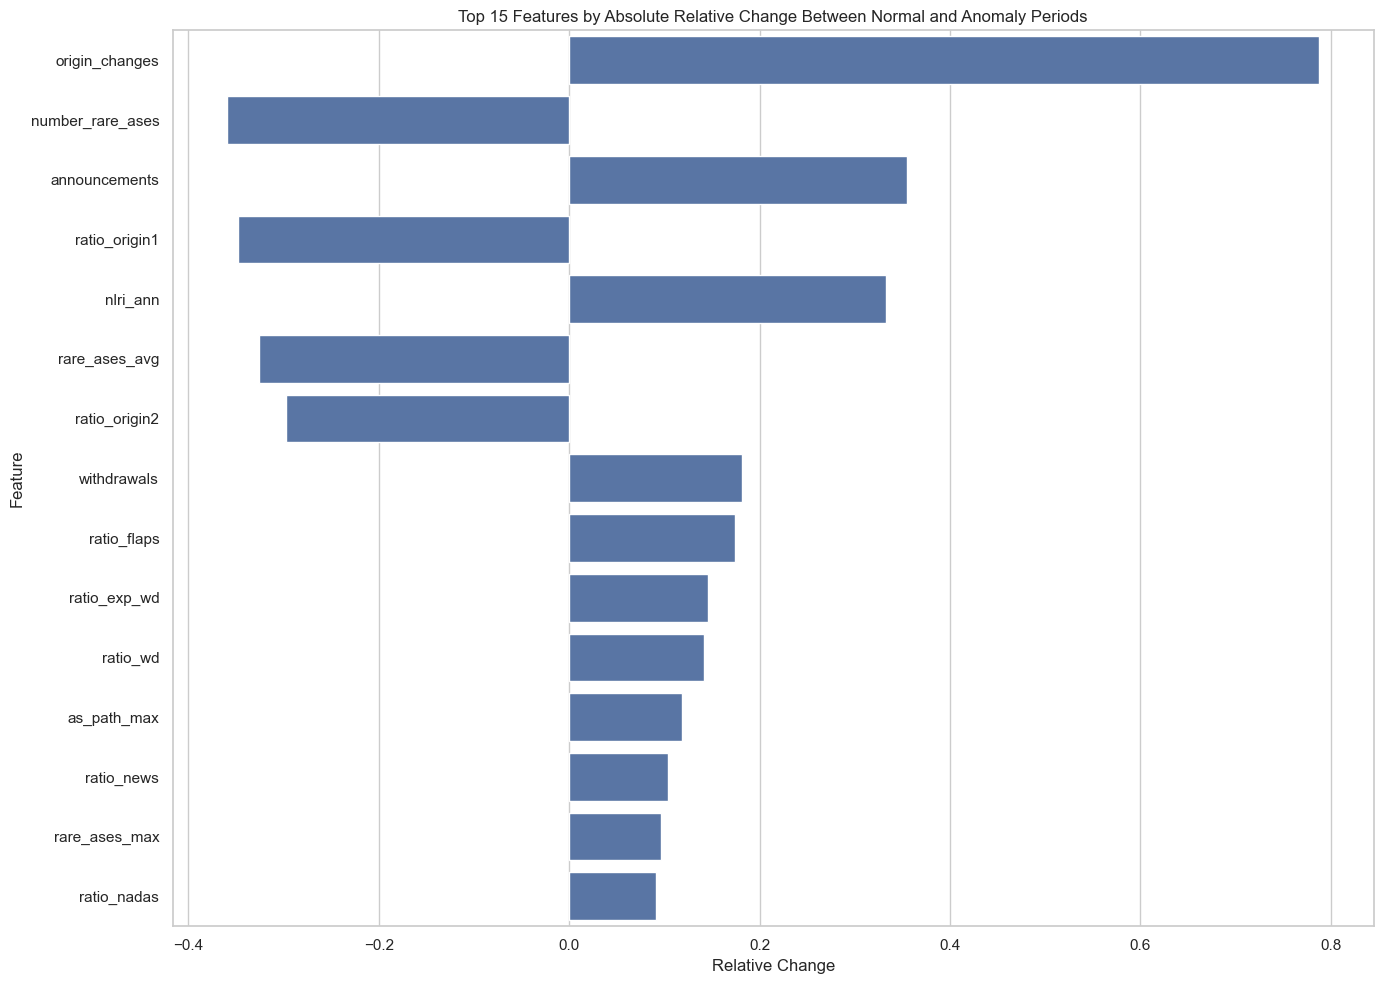

In [12]:
# Analyze feature importance for anomaly detection
# For each feature, calculate the mean difference between normal and anomaly periods
anomaly = df[df['class'] == 1]
normal = df[df['class'] == 0]

# Calculate mean differences
feature_diffs = {}
for col in X.columns:
    if col != 'class':
        normal_mean = normal[col].mean()
        anomaly_mean = anomaly[col].mean() if not anomaly.empty else 0
        
        # Prevent division by zero
        if normal_mean == 0:
            if anomaly_mean == 0:
                diff = 0
            else:
                diff = float('inf')
        else:
            diff = (anomaly_mean - normal_mean) / normal_mean
        
        feature_diffs[col] = diff

# Convert to DataFrame for better visualization
feature_diff_df = pd.DataFrame(list(feature_diffs.items()), columns=['Feature', 'Relative Change'])
feature_diff_df = feature_diff_df.sort_values('Relative Change', key=abs, ascending=False)

# Plot top features by absolute difference
plt.figure(figsize=(14, 10))
sns.barplot(x='Relative Change', y='Feature', data=feature_diff_df.head(15))
plt.title('Top 15 Features by Absolute Relative Change Between Normal and Anomaly Periods')
plt.tight_layout()
plt.show()

In [13]:
# Select top features based on difference analysis
top_features = feature_diff_df.head(15)['Feature'].tolist()
print("Selected top features:")
print(top_features)

# Extract selected features from dataset
X = X[top_features]
X_test = X_test[top_features]

Selected top features:
['origin_changes', 'number_rare_ases', 'announcements', 'ratio_origin1', 'nlri_ann', 'rare_ases_avg', 'ratio_origin2', 'withdrawals', 'ratio_flaps', 'ratio_exp_wd', 'ratio_wd', 'as_path_max', 'ratio_news', 'rare_ases_max', 'ratio_nadas']


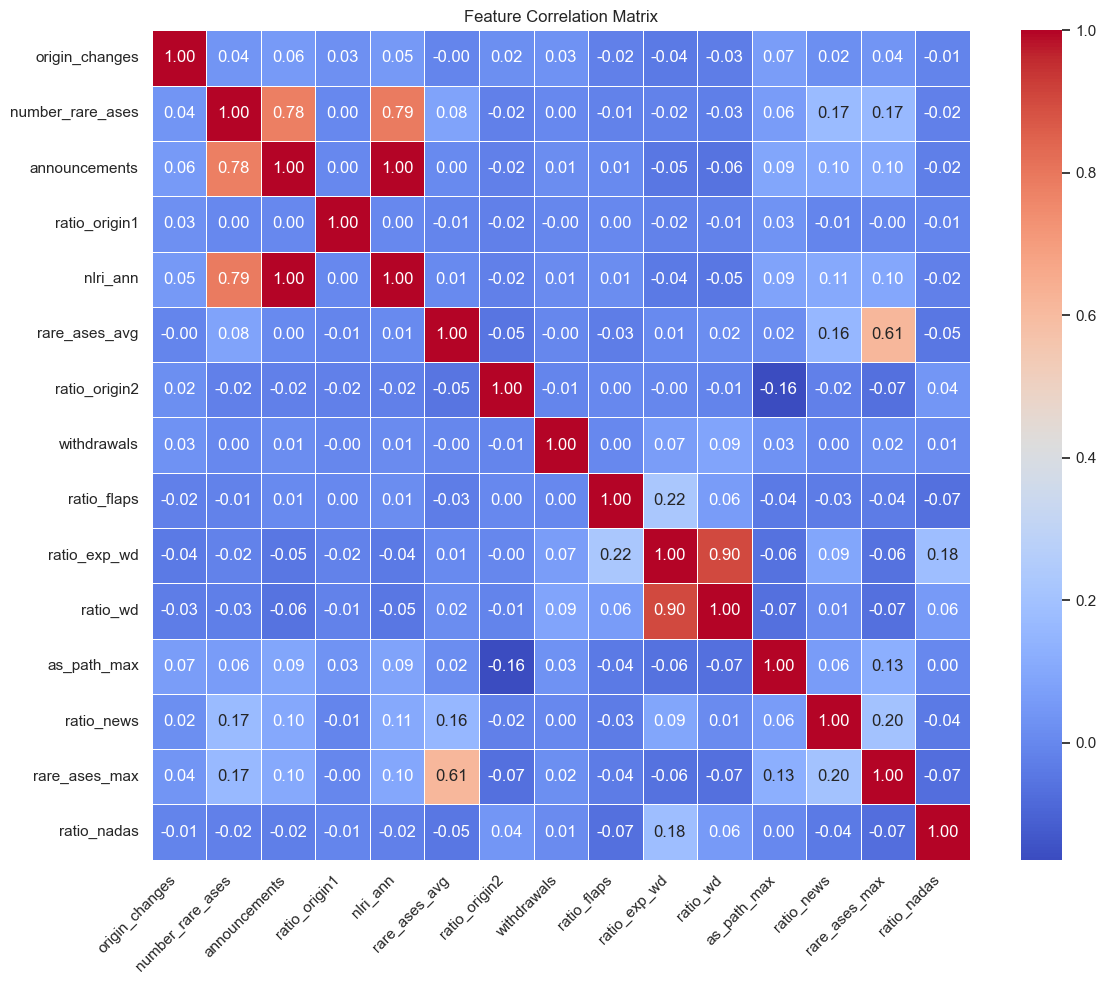

In [14]:
# Feature Correlation Matrix
feature_cols = X.select_dtypes(include=['number']).columns
X_features = df[feature_cols]
corr_matrix = X_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
# Feature engineering
window_size = 5  # in number of rows (or minutes if resampled)

for feature in top_features:
    X[f'{feature}_rolling_mean'] = X[feature].rolling(window=window_size).mean()
    X[f'{feature}_rolling_std'] = X[feature].rolling(window=window_size).std()
    X[f'{feature}_rolling_max'] = X[feature].rolling(window=window_size).max()
    X[f'{feature}_rolling_min'] = X[feature].rolling(window=window_size).min()
    X_test[f'{feature}_rolling_mean'] = X_test[feature].rolling(window=window_size).mean()
    X_test[f'{feature}_rolling_std'] = X_test[feature].rolling(window=window_size).std()
    X_test[f'{feature}_rolling_max'] = X_test[feature].rolling(window=window_size).max()
    X_test[f'{feature}_rolling_min'] = X_test[feature].rolling(window=window_size).min()



## 4. SVM Model Training and Hyperparameter Tuning

In [16]:
training = pd.concat([X, y], axis=1)
training = training.dropna()
X_train = training.drop(["class"], axis=1)
y_train = training["class"]

print(X_train.shape)

test = pd.concat([X_test, y_test], axis=1)
test = test.dropna()
X_test = test.drop(["class"], axis=1)
y_test = test["class"]

(17468, 75)


In [17]:
# Balance classes
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check class distribution
print(Counter(y_train))

Counter({0: 13461, 1: 13461})


In [18]:
# Create a pipeline with preprocessing and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

# Define the hyperparameter search space
param_grid = {
    'svm__C': [0.1, 1, 10],            
    'svm__gamma': ['scale', 0.01],      
    'svm__kernel': ['rbf']          
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best CV score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found:
{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best CV score: 0.8851


In [19]:
# Get the best model
best_model = grid_search.best_estimator_
svm = best_model

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

## 5. Model Evaluation with Advanced Metrics

In [20]:
# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8228
Precision: 0.2992
Recall: 0.0956
F1 Score: 0.1449

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      6066
           1       0.30      0.10      0.14      1130

    accuracy                           0.82      7196
   macro avg       0.57      0.53      0.52      7196
weighted avg       0.76      0.82      0.78      7196



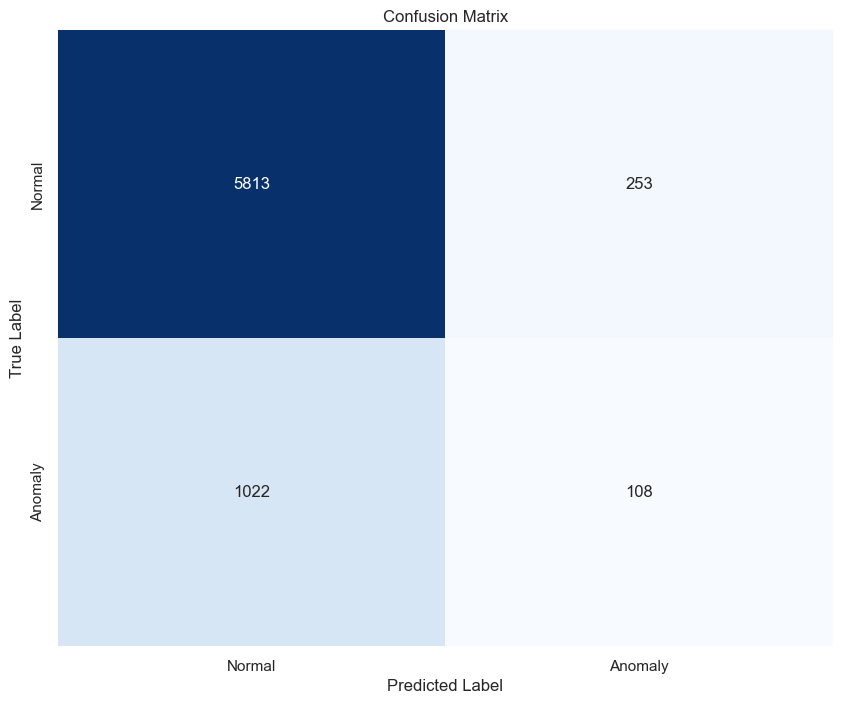

In [21]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

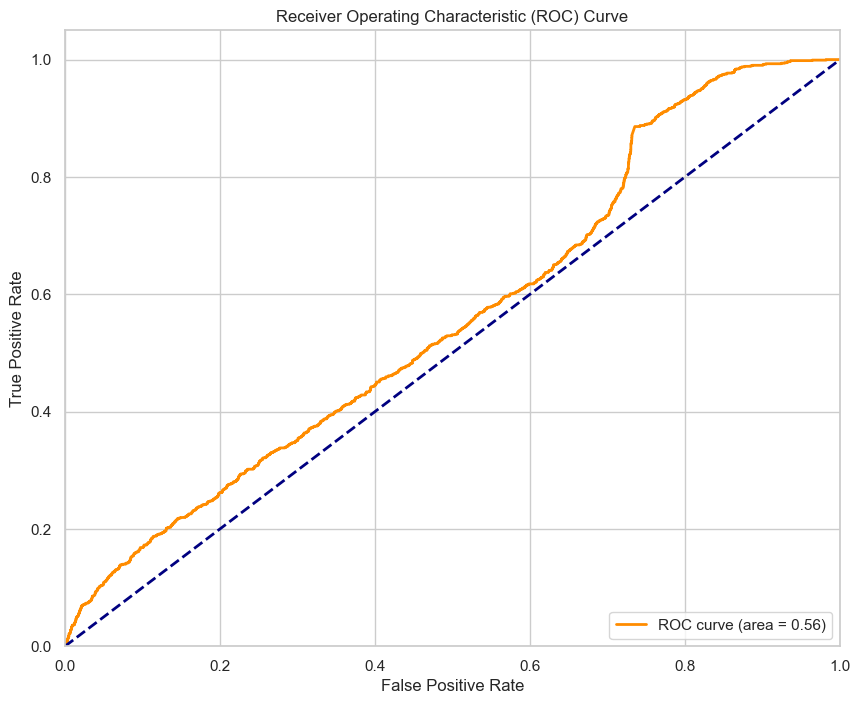

In [22]:
# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

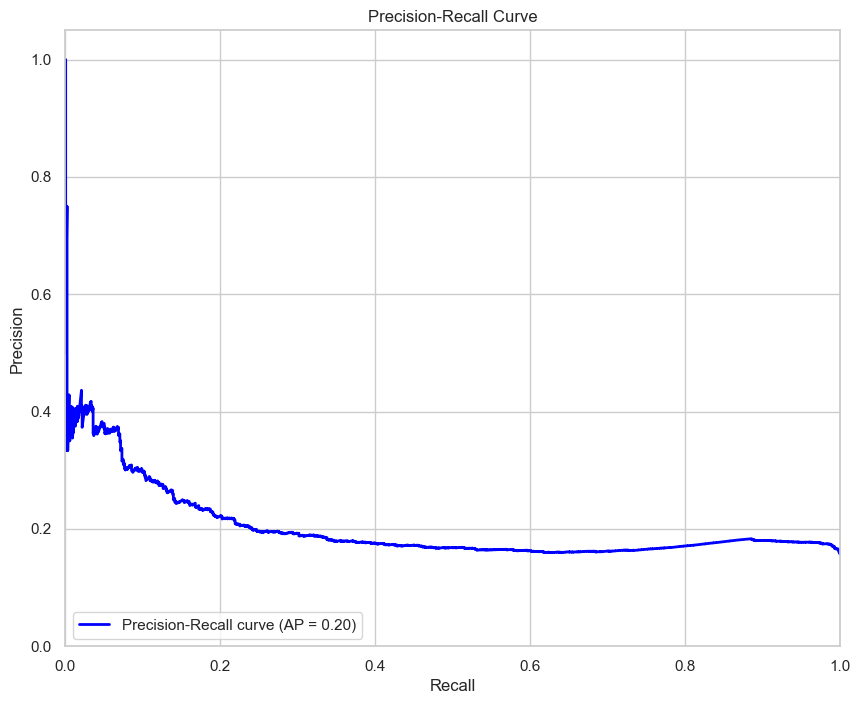

In [23]:
# Calculate and plot Precision-Recall curve
precision_values, recall_values, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall_values, precision_values, color='blue', lw=2, 
         label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

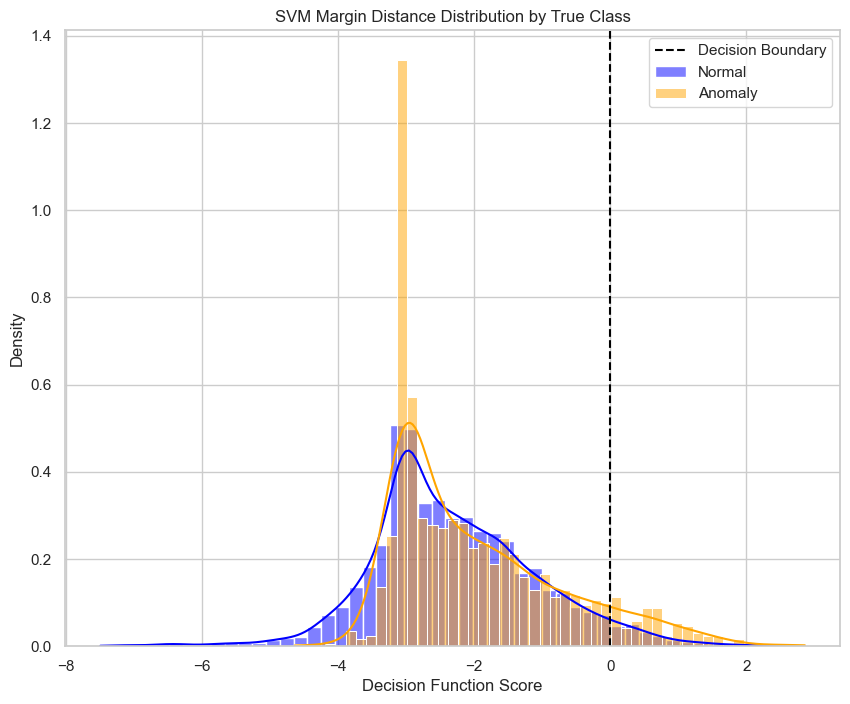

In [24]:
# Plot margin distances
distances = svm.decision_function(X_test)  # signed distance to margin

plt.figure(figsize=(10, 8))
sns.histplot(distances[y_test == 0], color='blue', label='Normal', kde=True, stat='density', bins=50)
sns.histplot(distances[y_test == 1], color='orange', label='Anomaly', kde=True, stat='density', bins=50)
plt.axvline(0, color='black', linestyle='--', label='Decision Boundary')
plt.title("SVM Margin Distance Distribution by True Class")
plt.xlabel("Decision Function Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

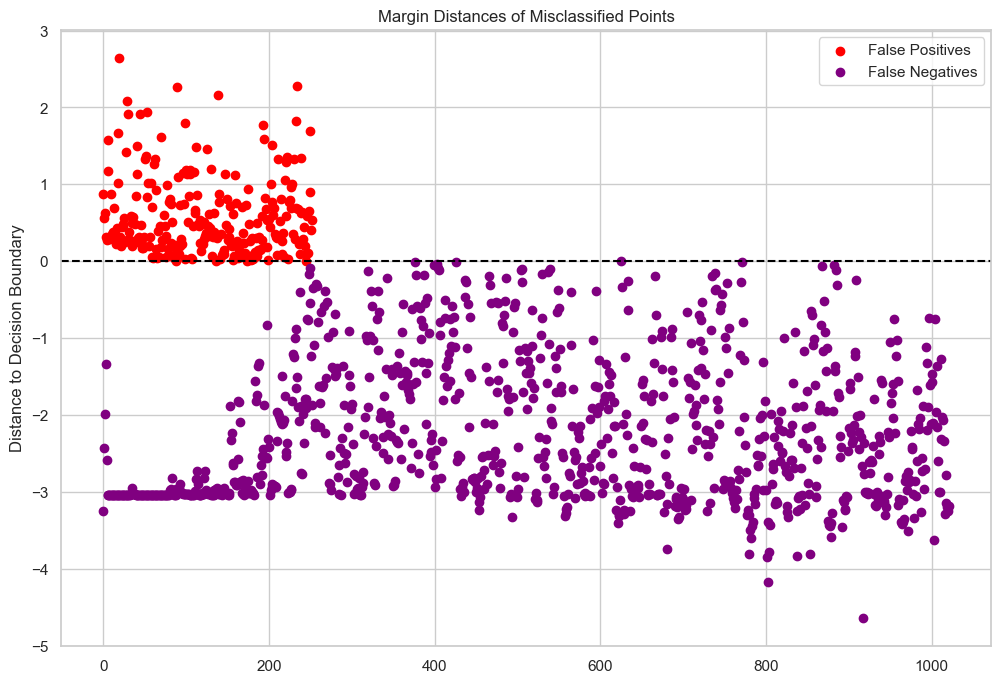

In [25]:
# Plot misclassifications
y_pred = svm.predict(X_test)

# Get false positives and false negatives
fp = (y_test == 0) & (y_pred == 1)
fn = (y_test == 1) & (y_pred == 0)

plt.scatter(range(len(distances[fp])), distances[fp], color='red', label='False Positives')
plt.scatter(range(len(distances[fn])), distances[fn], color='purple', label='False Negatives')
plt.axhline(0, color='black', linestyle='--')
plt.title("Margin Distances of Misclassified Points")
plt.ylabel("Distance to Decision Boundary")
plt.legend()
plt.show()

In [26]:
# Support vectors
svm = best_model.named_steps['svm']
support_vectors = svm.support_vectors_
print(f"Number of support vectors: {len(support_vectors)}")

Number of support vectors: 8444


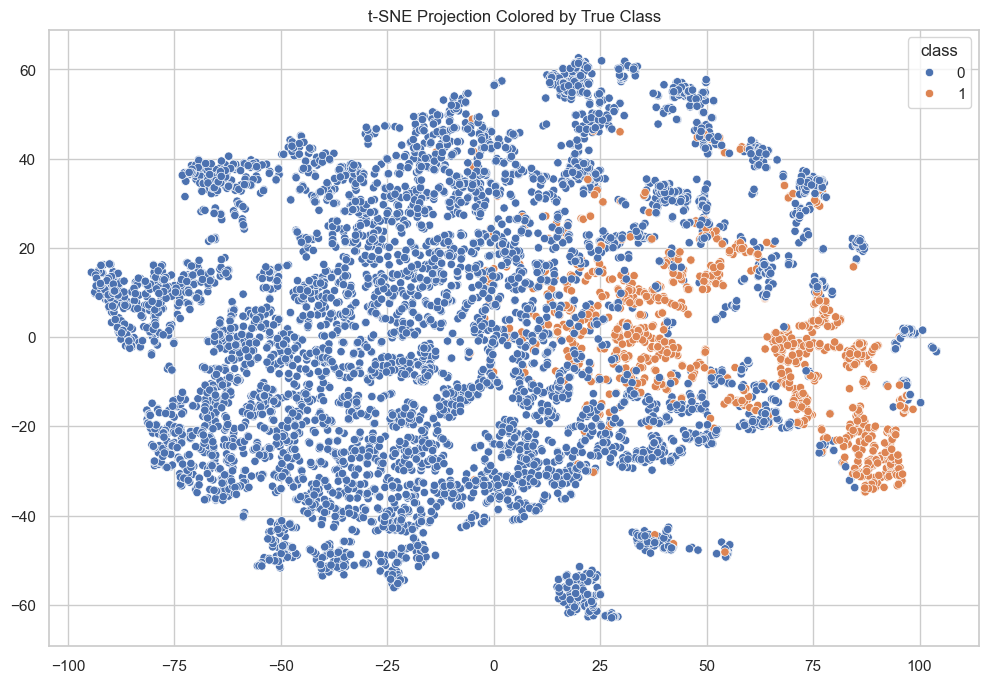

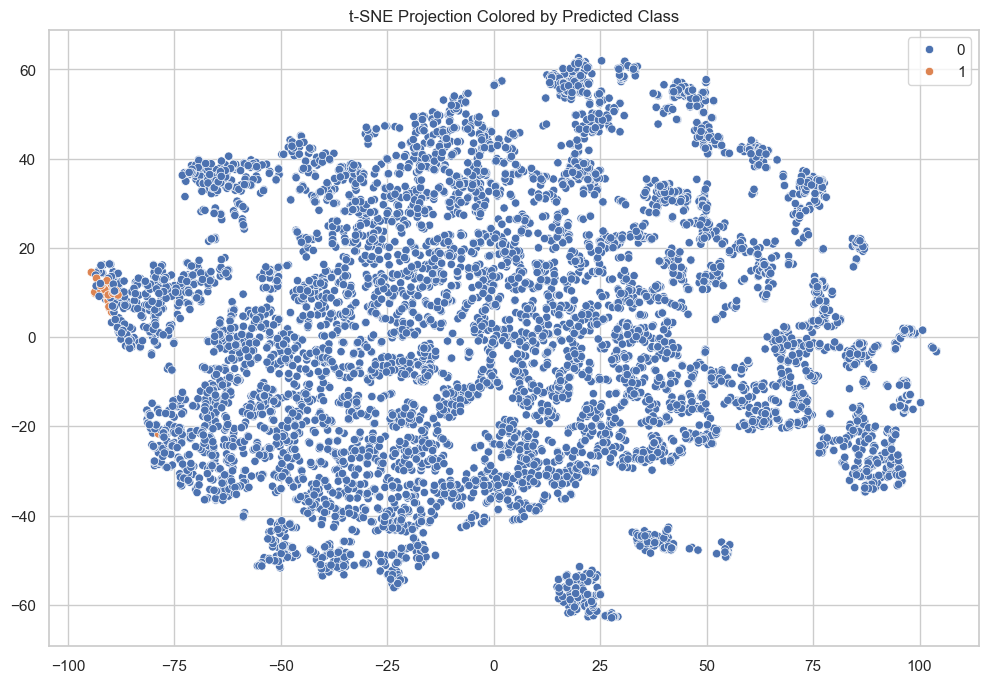

In [27]:
# T-SNE projection
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_test)

# Plot with true labels
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_test)
plt.title("t-SNE Projection Colored by True Class")
plt.show()

# Plot with predicted labels
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=svm.predict(X_test))
plt.title("t-SNE Projection Colored by Predicted Class")
plt.show()

Explained variance ratio: [0.13347208 0.09138253 0.07112486 0.0642709  0.04714704 0.04462262
 0.04392582 0.03995209 0.03902332 0.03727741 0.03414651 0.03054624
 0.02847061 0.02252759 0.02194803 0.01922337 0.01727794 0.01441433
 0.01402625 0.01343942 0.01295178 0.0128323  0.01240065 0.01173042
 0.01009538 0.00983944 0.00963303 0.0091131  0.00859889 0.00855045
 0.00816526 0.00797894]
Total explained variance: 0.95


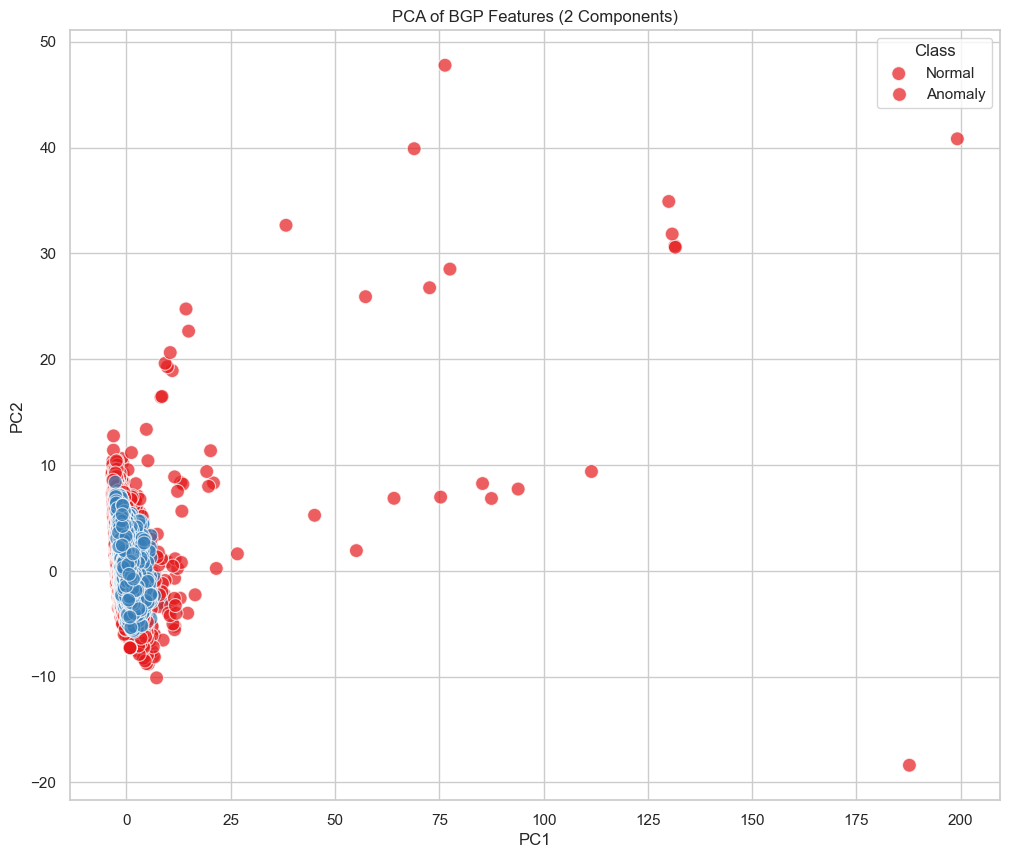

Top features for PC1:
nlri_ann_rolling_mean         0.290567
announcements_rolling_mean    0.290446
announcements_rolling_max     0.276150
nlri_ann_rolling_max          0.275501
announcements_rolling_std     0.269769
Name: PC1, dtype: float64


In [36]:
# PCA
# Apply PCA to reduce to 2 dimensions for visualization
dims = 32   # CHANGE THIS SO EXPLAINED VARIANCE IS >= 0.95
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=dims)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(dims)])
pca_df['class'] = y_train.values

# Plot PCA results
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('PCA of BGP Features (2 Components)')
plt.legend(title='Class', labels=['Normal', 'Anomaly'])
plt.show()

loadings = pca.components_.T  # shape: (original_features, 21)
loading_df = pd.DataFrame(loadings, index=X_train.columns, columns=[f"PC{i+1}" for i in range(dims)])

# View top contributing features to PC1
print("Top features for PC1:")
print(loading_df['PC1'].abs().sort_values(ascending=False).head(5))

  0%|          | 0/10 [00:00<?, ?it/s]

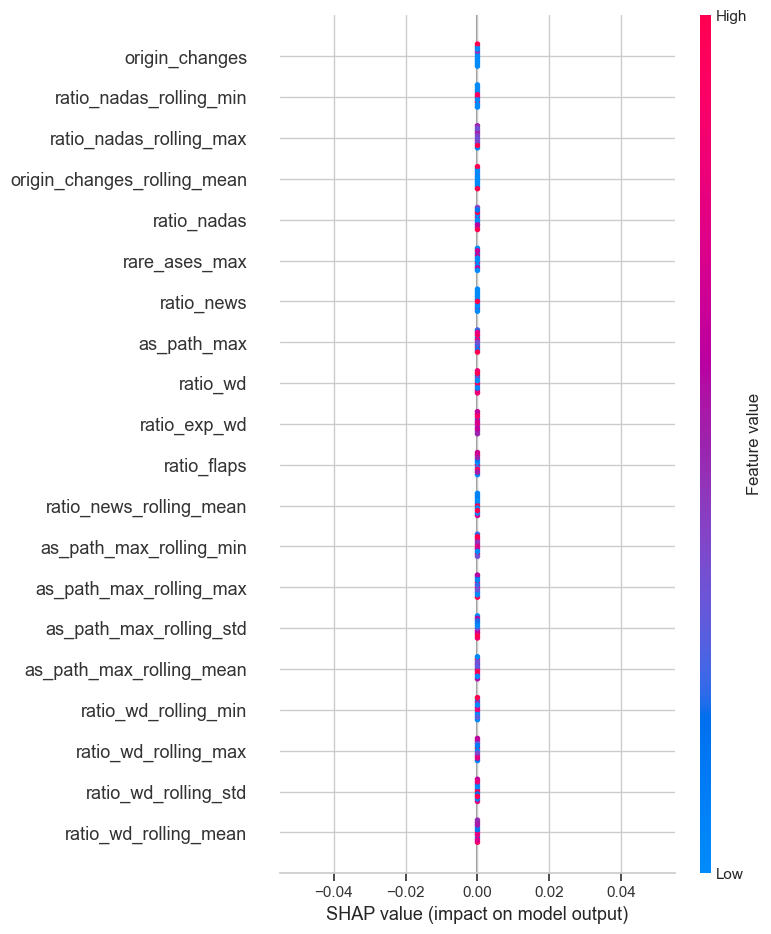

<Figure size 1200x800 with 0 Axes>

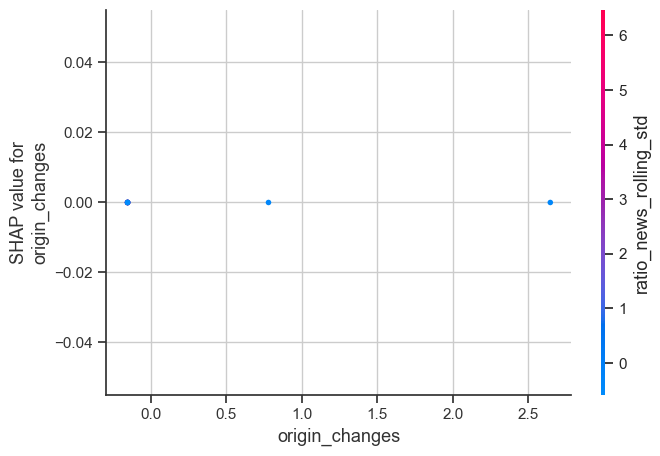

In [37]:
# SHAP Explanations
if EXPLAINABILITY_AVAILABLE:
    # Create a simpler model for SHAP analysis (to speed up computation)
    shap_model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', probability=True))
    ])
    shap_model.fit(X_train, y_train)
    
    # Use a subset of training data as background for the explainer
    X_train_sample = X_train.sample(min(100, len(X_train)), random_state=42)
    X_train_transformed = shap_model.named_steps['scaler'].transform(X_train_sample)
    
    # Create a SHAP KernelExplainer
    def f(x):
        return shap_model.predict_proba(x)[:,1]
    
    explainer = shap.KernelExplainer(f, X_train_transformed)
    
    # Select a sample of test instances to explain
    X_test_sample = X_test.sample(min(10, len(X_test)), random_state=42)
    X_test_transformed = shap_model.named_steps['scaler'].transform(X_test_sample)
    
    # Compute SHAP values
    shap_values = explainer.shap_values(X_test_transformed)
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=X.columns)
    
    # SHAP dependence plot for top feature
    top_feature_idx = np.argmax(np.abs(explainer.expected_value))
    top_feature = X_train.columns[top_feature_idx]
    
    plt.figure(figsize=(12, 8))
    shap.dependence_plot(top_feature_idx, shap_values, X_test_transformed, 
                         feature_names=X_train.columns)
else:
    print("SHAP analysis skipped because libraries are not installed.")